## Series temporales con Prophet: evolución del número de posts en Medium

En este segundo ejercicio intentaremos modelar el número de artículos que se publican diariamente en el blog [Medium](https://medium.com/), en el que aparecen con frecuencia artículos interesantes sobre inteligencia artificial. Comenzamos como siempre cargando las librerías que necesitaremos:

In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt

%matplotlib inline

Ahora subimos el dataset a nuestro espacio de trabajo de Colab desde el repositorio del curso y lo cargamos:

In [2]:
##### DOWNLOAD DATASET. ONLY IN COLAB !!!
!wget -P ./../data/ https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/Datasets/Tabular/medium_posts.csv.zip

--2021-10-26 10:38:13--  https://raw.githubusercontent.com/CenticMurcia/curso-ciencia-datos/master/Datasets/Tabular/medium_posts.csv.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4354594 (4.2M) [application/zip]
Saving to: ‘./../data/medium_posts.csv.zip.1’

medium_posts.csv.zi 100%[===================>]   4.15M  --.-KB/s    in 0.02s   

2021-10-26 10:38:13 (180 MB/s) - ‘./../data/medium_posts.csv.zip.1’ saved [4354594/4354594]



In [3]:
df = pd.read_csv('./../data/medium_posts.csv.zip', sep='\t')

Nos quedaremos solo con dos columnas: `published` y `url`. La primera nos indica el momento en el que se publica el artículo, y la segunda es su dirección web. También vamos a eliminar cualquier post duplicado y los valores perdidos que pudiese haber, y por último convertiremos la fecha al tipo datetime, ya que por defecto pandas la considera como una cadena de texto. Le echamos un vistazo a las primeras cinco filas del dataset ya limpiado, ordenando por la fecha:

In [4]:
df = df[['published', 'url']].dropna().drop_duplicates()
df['published'] = pd.to_datetime(df['published'])
df.sort_values(by=['published']).head(n=5)

,published,url
50931,1970-01-01 00:00:00.001000+00:00,https://medium.com/iiot
40243,1970-01-01 00:00:00.001000+00:00,https://medium.com/@ikaella/melon-rebranding-b...
37395,1970-01-18 05:11:46.500000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
37398,1970-01-18 05:11:58.200000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...
37394,1970-01-18 05:26:42.120000+00:00,http://www.novosti.rs/%D0%B2%D0%B5%D1%81%D1%82...


Vemos que aparecen artículos fechados en 1970, aunque Medium comenzó a funcionar el 15 de agosto de 2012, así que vamos a filtrar los posts a partir de esa fecha y llegando lasta el 26 de junio de 2017, ignorando los demás:

In [5]:
df = df[(df['published'] > '2012-08-15') & (df['published'] < '2017-06-26')].sort_values(by=['published'])
df.head(n=5)

,published,url
24630,2012-08-15 00:25:03.373000+00:00,https://medium.com/launch-day/jean-attempts-to...
24631,2012-08-15 00:25:29.419000+00:00,https://medium.com/launch-day/dan-and-kristin-...
17811,2012-08-15 00:34:59.502000+00:00,https://medium.com/i-m-h-o/the-world-is-social...
17281,2012-08-15 00:40:10.773000+00:00,https://medium.com/@karen/this-farm-table-1cfc...
12376,2012-08-15 00:58:25.898000+00:00,https://medium.com/@hattmodgins/lighting-strik...


In [6]:
df.tail(n=5)

,published,url
89430,2017-06-25 23:00:51.161000+00:00,https://medium.com/@svetlanavoreskova/yes-that...
62153,2017-06-25 23:01:38.625000+00:00,https://medium.com/the-foul-shot/the-timberwol...
62122,2017-06-25 23:36:01.171000+00:00,https://medium.com/push-the-pace/the-official-...
72471,2017-06-25 23:41:48.295000+00:00,https://medium.com/parti-xyz-developers/%EA%B4...
83283,2017-06-25 23:51:43+00:00,http://www.johanr.com/blog/people-support-dreams


Como pretendemos predecir el número de publicaciones al día vamos a agregar y contar los posts en cada momento del tiempo, creando una nueva columna `posts`:

In [7]:
aggr_df = df.groupby('published')[['url']].count()
aggr_df.columns = ['posts']

In [8]:
aggr_df.head()

,posts
published,
2012-08-15 00:25:03.373000+00:00,1
2012-08-15 00:25:29.419000+00:00,1
2012-08-15 00:34:59.502000+00:00,1
2012-08-15 00:40:10.773000+00:00,1
2012-08-15 00:58:25.898000+00:00,1


Como el *timestamp* incluye fracciones de segundo necesitaremos agregar en intervalos (*bins*) de 24 horas, lo que en el argot del análisis de series temporales se denomina *resampling*. Como lo que vamos a hacer es reducir la frecuencia de muestreo, se denomina *downsampling*. `pandas` incorpora una función que realiza esta labor automáticamente:

In [9]:
daily_df = aggr_df.resample('D').apply(sum)
daily_df.head(n=5)

,posts
published,
2012-08-15 00:00:00+00:00,16
2012-08-16 00:00:00+00:00,11
2012-08-17 00:00:00+00:00,4
2012-08-18 00:00:00+00:00,2
2012-08-19 00:00:00+00:00,1


Ahora representaremos gráficamente nuestros datos para intentar detectar visualmente patrones estacionales y desviaciones o anormalidades. Usaremos la librería `Plotly`, que permite crear gráficos interactivos, crearemos nuestra propia función de representación, y la usaremos con nuestro dataset:

In [10]:
from plotly.offline import init_notebook_mode, iplot
from plotly import graph_objs as go

In [11]:
def plotly_df(df, title=''):
    """Visualize all the dataframe columns as line plots."""
    common_kw = dict(x=df.index, mode='lines')
    data = [go.Scatter(y=df[c], name=c, **common_kw) for c in df.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    iplot(fig, show_link=False)

In [12]:
plotly_df(daily_df, title='Posts on Medium (daily)')

Resulta complicado sacar conclusiones de este gráfico, aunque sea interactivo y se pueda desplazar y hacer zoom, ya que tiene demasiada frecuencia y ruido. Por ello vamos a realizar un nuevo *resampling* agregando posts por semanas. No es la única opción para aumentar la relación señal/ruido, también podríamos hacer un [alisado por media móvil](https://en.wikipedia.org/wiki/Moving_average) o un [alisado exponencial](https://en.wikipedia.org/wiki/Exponential_smoothing).

In [13]:
weekly_df = daily_df.resample('W').apply(sum)
plotly_df(weekly_df, title='Posts on Medium (weekly)')

Esta gráfica sometida a *downsampling* resulta más fácil de analizar visualmente, por ejemplo resulta evidente el efecto de las fiestas de navidad.

Vemos también que durante los primeros años de Medium el número de publicaciones era muy reducido y no representaba el comportamiento posterior, por lo que para hacer predicciones vamos a utilizar solo datos a partir de 2015:

In [14]:
daily_df = daily_df.loc[daily_df.index >= '2015-01-01']
daily_df.head(n=5)

,posts
published,
2015-01-01 00:00:00+00:00,8
2015-01-02 00:00:00+00:00,11
2015-01-03 00:00:00+00:00,11
2015-01-04 00:00:00+00:00,8
2015-01-05 00:00:00+00:00,27


Las conclusiones más importantes que debemos sacar de los gráficos anteriores es que nuestros datos representan un proceso no estacionario con una tendencia muy marcada de crecimiento, en el que se aprecian contribuciones estacionales tanto semanales como anuales y también la contribución de los días anómalos (*holidays*).

Ya prodemos proceder a modelar nuestra serie temporal y a hacer predicciones. Como en el notebook anterior, es importante asegurarse de que tenemos instaladas las versiones adecuadas de Prophet, holidays y pandas para evitar incompatibilidades:

In [15]:
# !pip install fbprophet
# !pip install holidays==0.9.8
# !pip install pandas==0.25.3

In [16]:
from fbprophet import Prophet

import logging
logging.getLogger().setLevel(logging.ERROR)

Ahora procedemos a convertir nuestros datos al formato que requiere Prophet:

In [17]:
df = daily_df.reset_index()
df.columns = ['ds', 'y']
df.ds = df.ds.dt.tz_localize(None)
df.tail(n=5)

,ds,y
902,2017-06-21,422
903,2017-06-22,441
904,2017-06-23,421
905,2017-06-24,277
906,2017-06-25,253


De forma general se recomienda incluir como mínimo un año de datos en el modelado de series temporales, en nuestro caso tenemos varios años. Y como suele ser también habitual, dividiremos el dataset en conjuntos de entrenamiento y validación. Quitaremos el último mes de la serie para ver la precisión de nuestras predicciones:

In [18]:
prediction_size = 30
train_df = df[:-prediction_size]
train_df.tail(n=5)

,ds,y
872,2017-05-22,341
873,2017-05-23,388
874,2017-05-24,375
875,2017-05-25,298
876,2017-05-26,269


Pasamos ya a construir un objeto `Prophet` con los parámetros por defecto y lo entrenamos con el conjunto de entrenamiento y el comando `fit`. Usaremos también el método `Prophet.make_future_dataframe` para crear un dataframe que se extienda 30 días en el futuro para incluir los valores que quitamos anteriormente:

In [19]:
m = Prophet()
m.fit(train_df);

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [20]:
future = m.make_future_dataframe(periods=prediction_size)
future.tail(n=5)

,ds
902,2017-06-21
903,2017-06-22
904,2017-06-23
905,2017-06-24
906,2017-06-25


En la variable `forecast` colocaremos las predicciones que realizamos con los datos de validación. Al usar el comando `predict` no solo realizamos las predicciones, además se realiza un ajuste con todos los datos históricos:

In [21]:
forecast = m.predict(future)
forecast.tail(n=5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
902,2017-06-21,275.499808,267.353457,316.140310,275.188426,275.812216,15.811035,15.811035,15.811035,17.134647,17.134647,17.134647,-1.323612,-1.323612,-1.323612,0.0,0.0,0.0,291.310843
903,2017-06-22,276.206588,263.423026,312.870366,275.870669,276.539828,11.932142,11.932142,11.932142,13.071055,13.071055,13.071055,-1.138913,-1.138913,-1.138913,0.0,0.0,0.0,288.138730
904,2017-06-23,276.913368,252.980776,304.297527,276.550395,277.268374,2.528897,2.528897,2.528897,3.475074,3.475074,3.475074,-0.946177,-0.946177,-0.946177,0.0,0.0,0.0,279.442265
905,2017-06-24,277.620148,218.285088,268.102178,277.231316,278.013435,-34.775958,-34.775958,-34.775958,-34.026178,-34.026178,-34.026178,-0.749780,-0.749780,-0.749780,0.0,0.0,0.0,242.844190
906,2017-06-25,278.326928,224.309096,272.641165,277.912233,278.750763,-31.135987,-31.135987,-31.135987,-30.581960,-30.581960,-30.581960,-0.554027,-0.554027,-0.554027,0.0,0.0,0.0,247.190941


El dataframe resultante contiene varias columnas con detalles sobre la predicción, incluyendo los componentes de tendencia y estacionalidad con sus correspondientes intervalos de confianza. Las predicciones en sí están en la columna `yhat`.

La propia librería `Prophet` tiene sus propias herramientas para representar los resultados. Por ejemplo, podemos usar el método `Prophet.plot`:

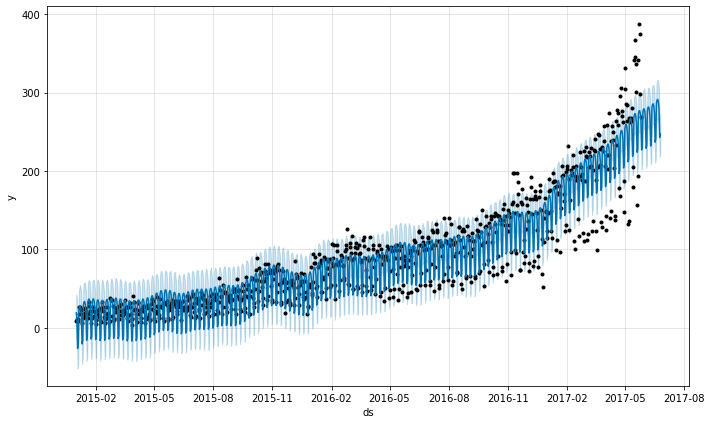

In [22]:
m.plot(forecast);

Esta gráfica no es muy informativa, la única conclusión evidente que sacamos es que hay muchos valores ubicados fuera del inervalo de confianza (*outliers*). Resulta más útil utilizar la función  `Prophet.plot_components`, que nos permite representar separadamente cada componente de la serie: tendencia, componente anual y componente semanal. Si hubiésemos introducido informacion sobre días anómalos (*holidays*) también aparecerían en esta gráfica:

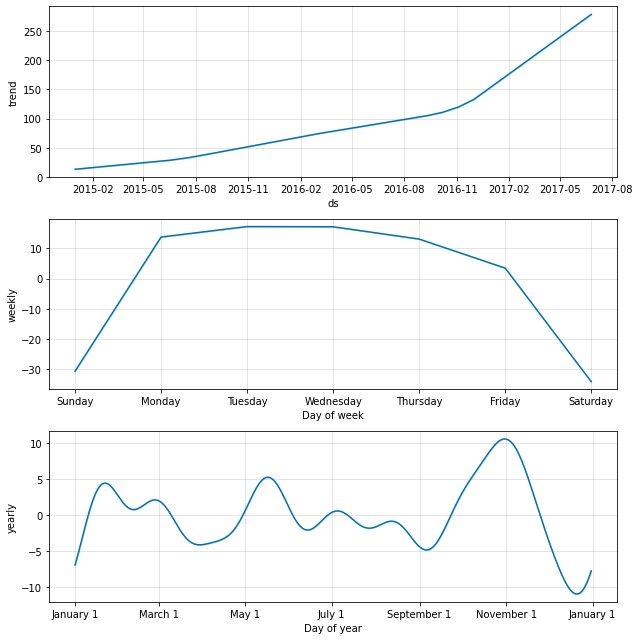

In [23]:
m.plot_components(forecast);

Se observa muy claramente que Prophet ha encontrado un punto de cambio de tendencia alrededor de 2016, 
cuando se aceleró el crecimiento. También se ve que los sábados y domingos se publican menos posts que otros días, y que en navidad se suele producir un descenso muy marcado.

Vamos ahora a determinar la calidad de nuestro modelo calculando el error en los últimos 30 días que usamos para predecir. Para ello tendremos que comparar los valores observados (verdaderos) $y_i$ y los valores predichos $\hat{y}_i$. Si echamos un vistazo al objeto `forecast` que aloja nuestras predicciones veremos que contiene toda la información que necesitamos menos los valores observados, por lo que habrá que traerlos desde el dataset original. Para ello definiremos una función, ya que la usaremos varias veces:

In [24]:
print(', '.join(forecast.columns))

ds, trend, yhat_lower, yhat_upper, trend_lower, trend_upper, additive_terms, additive_terms_lower, additive_terms_upper, weekly, weekly_lower, weekly_upper, yearly, yearly_lower, yearly_upper, multiplicative_terms, multiplicative_terms_lower, multiplicative_terms_upper, yhat


In [25]:
def make_comparison_dataframe(historical, forecast):
    """Join the history with the forecast.
    
       The resulting dataset will contain columns 'yhat', 'yhat_lower', 'yhat_upper' and 'y'.
    """
    return forecast.set_index('ds')[['yhat', 'yhat_lower', 'yhat_upper']].join(historical.set_index('ds'))

Apliquemos esta función a nuestras predicciones:

In [26]:
df.ds = df.ds.dt.tz_localize(None)
cmp_df = make_comparison_dataframe(df, forecast)
cmp_df.tail(n=5)

,yhat,yhat_lower,yhat_upper,y
ds,,,,
2017-06-21,291.310843,267.353457,316.140310,422
2017-06-22,288.138730,263.423026,312.870366,441
2017-06-23,279.442265,252.980776,304.297527,421
2017-06-24,242.844190,218.285088,268.102178,277
2017-06-25,247.190941,224.309096,272.641165,253


Nos falta por definir una función más para determinar la calidad de las predicciones calculando los errores MAPE y MAE:

In [27]:
def calculate_forecast_errors(df, prediction_size):
    """Calculate MAPE and MAE of the forecast.
    
       Args:
           df: joined dataset with 'y' and 'yhat' columns.
           prediction_size: number of days at the end to predict.
    """
    
    # Make a copy
    df = df.copy()
    
    # Now we calculate the values of e_i and p_i according to the formulas given in the article above.
    df['e'] = df['y'] - df['yhat']
    df['p'] = 100 * df['e'] / df['y']
    
    # Recall that we held out the values of the last `prediction_size` days
    # in order to predict them and measure the quality of the model. 
    
    # Now cut out the part of the data which we made our prediction for.
    predicted_part = df[-prediction_size:]
    
    # Define the function that averages absolute error values over the predicted part.
    error_mean = lambda error_name: np.mean(np.abs(predicted_part[error_name]))
    
    # Now we can calculate MAPE and MAE and return the resulting dictionary of errors.
    return {'MAPE': error_mean('p'), 'MAE': error_mean('e')}

In [28]:
for err_name, err_value in calculate_forecast_errors(cmp_df, prediction_size).items():
    print(err_name, err_value)

MAPE 22.64085771181396
MAE 70.02107834666941


Vemos que el error relativo de nuestras predicciones es de alrededor de 22.7% y en promedio nos equivocamos por alrededor de 70 publicaciones.

Para una mejor visualización del modelo vamos a crear nuestra propia función `show_forecast`, incluyendo los valores observados, las predicciones y los intervalos de confianza. Primero representamos los datos para un periodo de tiempo  más corto, para distinguir mejor los puntos. Luego mostramos la eficiencia del modelo para el periodo de los últimos 30 días. Y por último usamos `Plotly` para hacer la gráfica interactiva. Para más información sobre cómo funciona `Plotly` puede consultarse su [documentación](https://plot.ly/python/)):

In [29]:
def show_forecast(cmp_df, num_predictions, num_values, title):
    """Visualize the forecast."""
    
    def create_go(name, column, num, **kwargs):
        points = cmp_df.tail(num)
        args = dict(name=name, x=points.index, y=points[column], mode='lines')
        args.update(kwargs)
        return go.Scatter(**args)
    
    lower_bound = create_go('Lower Bound', 'yhat_lower', num_predictions,
                            line=dict(width=1),
                            marker=dict(color="green"))
    upper_bound = create_go('Upper Bound', 'yhat_upper', num_predictions,
                            line=dict(width=1),
                            marker=dict(color="green"),
                            fillcolor='rgba(68, 68, 68, 0.3)', 
                            fill='tonexty')
    forecast = create_go('Forecast', 'yhat', num_predictions,
                         line=dict(color='rgb(31, 119, 180)'))
    actual = create_go('Actual', 'y', num_values,
                       marker=dict(color="red"))
    
    # In this case the order of the series is important because of the filling
    data = [lower_bound, upper_bound, forecast, actual]

    layout = go.Layout(yaxis=dict(title='Posts'), title=title, showlegend = False)
    fig = go.Figure(data=data, layout=layout)
    iplot(fig, show_link=False)

show_forecast(cmp_df, prediction_size, 100, 'New posts on Medium')

A primera vista se observa que las predicciones no son excesivamente buenas, se obtiene un valor relativamente alto de MAPE, que parece indicar que el modelo no es capaz de capturar la magnitud del efecto estacional semanal. Se observa que muchas predicciones caen fuera del intervalo de confianza.

En realidad, Prophet no funciona bien con series temporales con cambios en su varianza, al menos si se usan los parámetros por defecto. Para solucionarlo podemos aplicar una transformación de nuestros datos, siendo la más frecuente y efectiva la [transformación de Box-Cox](http://onlinestatbook.com/2/transformations/box-cox.html).

Se trata de una transformación monotónica que se usa para estabilizar la varianza. Usaremos la transformacíon Box-Cox de un único parámetro $\lambda$, según la siguiente expresión:

$$
\begin{equation}
  boxcox^{(\lambda)}(y_{i}) = \begin{cases}
    \frac{\displaystyle y_{i}^{\lambda} - 1}{\displaystyle \lambda} & \text{si $\lambda \neq 0$}.\\
    ln(y_{i}) & \text{si $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

También tendremos que definir la inversa de dicha transformación, para reconvertir los datos a su formato original:

$$
\begin{equation}
  invboxcox^{(\lambda)}(y_{i}) = \begin{cases}
    e^{\left (\frac{\displaystyle ln(\lambda y_{i} + 1)}{\displaystyle \lambda} \right )} & \text{si $\lambda \neq 0$}.\\
    e^{y_{i}} & \text{si $\lambda = 0$}.
  \end{cases}
\end{equation}
$$

Definimos esta transformación inversa y preparamos nuestro dataset estableciendo su índice:

In [30]:
def inverse_boxcox(y, lambda_):
    return np.exp(y) if lambda_ == 0 else np.exp(np.log(lambda_ * y + 1) / lambda_)

In [31]:
train_df2 = train_df.copy().set_index('ds')

Usaremos la función `stats.boxcox` de la librería `Scipy`, que aplica la transformación Box–Cox y que devuelve dos valores. El primero es la serie transformada, y el segundo es valor óptimo estimado de $\lambda$ en términos de máxima verosimilitud:

In [32]:
train_df2['y'], lambda_prophet = stats.boxcox(train_df2['y'])
train_df2.reset_index(inplace=True)

Creamos ahora un nuevo modelo de `Prophet` y repetimos el proceso de ajuste y predicción realizado anteriormente, revertiendo luego la transformación Box-Cox con nuestra función y el valor que hemos determinado para $\lambda$:

In [33]:
m2 = Prophet()
m2.fit(train_df2)
future2 = m2.make_future_dataframe(periods=prediction_size)
forecast2 = m2.predict(future2)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [34]:
for column in ['yhat', 'yhat_lower', 'yhat_upper']:
    forecast2[column] = inverse_boxcox(forecast2[column], lambda_prophet)

Ahora reutilizamos las funciones que definimos anteriormente para comparar valores observados y predichos y calcular errores, comprobando que ambos errores MAPE y MAE se reducen casi a la mitad:

In [35]:
cmp_df2 = make_comparison_dataframe(df, forecast2)
for err_name, err_value in calculate_forecast_errors(cmp_df2, prediction_size).items():
    print(err_name, err_value)

MAPE 12.034640875645486
MAE 40.923902597393194


Por último volvemos a representar gráficamente los resultados, comprobando que los cambios semanales ahora sí que encajan mejor en el modelo.

In [36]:
show_forecast(cmp_df, prediction_size, 100, 'No transformations')
show_forecast(cmp_df2, prediction_size, 100, 'Box–Cox transformation')

Hemos visto que Prophet es una herramienta muy potente y fácil de usar, aunque las predicciones que realiza con la configuración por defecto no sean [ideales](https://en.wikipedia.org/wiki/No_free_lunch_in_search_and_optimization). Para afinar los modelos hay que ajustar muchos parámetros y realizar transformaciones de los datos, si son necesarias. Es una tarea árdua y compleja, que requiere de muchos conocimientos y experiencia. Sin embargo, con muy poca experiencia podemos crear muy facilmente modelos que consideran muchos efectos, como los estacionales o los días anormales (festivos).

## Referencias

- Repositorio oficial de [Prophet](https://github.com/facebookincubator/prophet) en GitHub.
- Documentación oficial de [Prophet](https://facebookincubator.github.io/prophet/docs/quick_start.html).
- El artículo científico de Taylor y Letham, ["Forecasting at scale"](https://facebookincubator.github.io/prophet/static/prophet_paper_20170113.pdf), en el que se explica el algoritmo con el que trabaja `Prophet`.
- [Forecasting Website Traffic Using Facebook’s Prophet Library](http://pbpython.com/prophet-overview.html) — Una introducción práctica a `Prophet` con un ejemplo para predecir el tráfico de una página web.
- Rob J. Hyndman, George Athanasopoulos ["Forecasting: principles and practice"](https://www.otexts.org/fpp) – Un libro excelente sobre análisis de series temporales.